In [1]:
import os

### Download and load texts/data
Download from raw imdb from http://mng.bz/0tIo 

In [2]:
imdb_dir = '/Users/szalmaf/Data/aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

In [3]:
labels = []
texts = []

In [4]:
for label_type in ['neg', 'pos']:
    directory = os.path.join(train_dir, label_type)
    for file_name in os.listdir(directory):
        if file_name[-4:] == '.txt':
            file = open(os.path.join(directory, file_name))
            texts.append(file.read())
            file.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

### Tokenize texts

In [5]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

Using TensorFlow backend.


In [6]:
max_words = 10000 # max number of words in vocabulary
training_samples = 15000 
validation_samples = 10000
maxlen = 100 # max length of reviews

In [7]:
tokenizer = Tokenizer(num_words=max_words)

In [8]:
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

In [9]:
word_index = tokenizer.word_index
print('Found %s number of unique tokens: ', len(word_index))

Found %s number of unique tokens:  88582


In [10]:
data = pad_sequences(sequences, maxlen=maxlen)

In [11]:
labels = np.asarray(labels)
print('Shape of data tensor: ', data.shape)
print('Shape of label tensor: ', labels.shape)

Shape of data tensor:  (25000, 100)
Shape of label tensor:  (25000,)


### Shuffle data to create training and validation sets

In [12]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices) # shuffles indices in place
data = data[indices]
labels = labels[indices]

In [13]:
x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples:training_samples + validation_samples]
y_val = labels [training_samples: training_samples + validation_samples]

### Loading and parsing Glove word-embeddings

In [14]:
glove_embedding_dir = '/Users/szalmaf/Data/glove'

embeddings_index = {}
f = open(os.path.join(glove_embedding_dir, 'glove.6B.100d.txt'))
for line in f:
    key_value = line.split()
    word = key_value[0]
    values = key_value[1:]
    embeddings_index[word] = values
f.close()

print('Number of %s word vectors.', len(embeddings_index))

Number of %s word vectors. 400000


### Prepare word-embeddings matrix for our word-index

In [15]:
embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

### Set up neural network model

In [16]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Embedding

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [17]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


### Load Glove embeddings into model's Embedding layer

In [18]:
model.layers[0].set_weights([embedding_matrix])
# model.layers[0].trainable = False

### Training and evaluating model

In [19]:
model.compile(optimizer='rmsprop', 
              loss='binary_crossentropy', 
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=30, 
                    batch_size=32, 
                    validation_data=(x_val, y_val))
model.save_weights('01d_pretrained_glove_model.h5')

Train on 15000 samples, validate on 10000 samples
Epoch 1/30
15000/15000 [==============================] - 8s 551us/step - loss: 0.6421 - acc: 0.6657 - val_loss: 0.6890 - val_acc: 0.6388
Epoch 2/30
15000/15000 [==============================] - 8s 523us/step - loss: 0.3964 - acc: 0.8215 - val_loss: 0.5280 - val_acc: 0.7560
Epoch 3/30
15000/15000 [==============================] - 8s 519us/step - loss: 0.2781 - acc: 0.8831 - val_loss: 0.4226 - val_acc: 0.8189
Epoch 4/30
15000/15000 [==============================] - 8s 519us/step - loss: 0.1908 - acc: 0.9247 - val_loss: 0.5734 - val_acc: 0.7849
Epoch 5/30
15000/15000 [==============================] - 8s 520us/step - loss: 0.1213 - acc: 0.9548 - val_loss: 0.7265 - val_acc: 0.7766
Epoch 6/30
15000/15000 [==============================] - 7s 492us/step - loss: 0.0563 - acc: 0.9817 - val_loss: 0.6264 - val_acc: 0.8043
Epoch 7/30
15000/15000 [==============================] - 7s 489us/step - loss: 0.0249 - acc: 0.9933 - val_loss: 0.7437 - 

In [20]:
history.history

{'acc': [0.66573333333333329,
  0.82146666666666668,
  0.88306666669845579,
  0.92473333330154417,
  0.95479999999999998,
  0.98166666666666669,
  0.99326666666666663,
  0.99760000000000004,
  0.99880000000000002,
  0.9996666666666667,
  0.99906666666666666,
  0.9996666666666667,
  0.9996666666666667,
  0.99986666666666668,
  0.99986666666666668,
  0.99986666666666668,
  0.99980000000000002,
  0.99973333333333336,
  0.99986666666666668,
  0.99960000000000004,
  0.99986666666666668,
  0.99993333333333334,
  0.99993333333333334,
  0.99986666666666668,
  1.0,
  0.99986666666666668,
  0.99986666666666668,
  0.99993333333333334,
  0.99980000000000002,
  0.99973333333333336],
 'loss': [0.64212950938542679,
  0.39643926332791646,
  0.27810675925413769,
  0.19076611422697703,
  0.12129493263165156,
  0.056332085081934928,
  0.024864669998114309,
  0.0096314603625175851,
  0.003854277772832817,
  0.0017284460640784043,
  0.0024709899242356189,
  0.00083887779821297957,
  0.0013516236289503165,


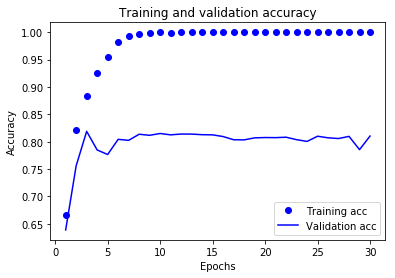

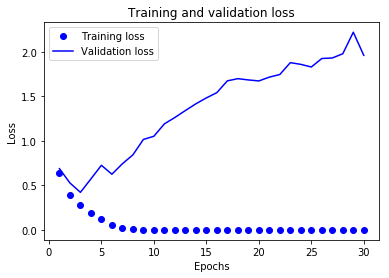

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [26]:
test_dir = os.path.join(imdb_dir, 'test')
labels = []
texts = []
for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)
sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)            

In [28]:
model.load_weights('01d_pretrained_glove_model.h5')
model.evaluate(x_test, y_test)

25000/25000 [==============================] - 1s 55us/step


[1.94498510061339, 0.80596000000000001]